## Simulate non-isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame
from data_models.data_model_helpers import export_blockvisibility_to_hdf5, export_skymodel_to_hdf5, \
    export_skycomponent_to_hdf5

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents
from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux, select_neighbouring_components
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits
from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image



from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import predictcal_skymodel_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import export_blockvisibility_to_hdf5, export_skymodel_to_hdf5, export_gaintable_to_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client



In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

### Set up the observation: 10 minutes at transit, with 10s integration.

In [4]:
nfreqwin = 1
ntimes = 61
rmax = 550.0
dec = -55.0 * u.deg
frequency = numpy.linspace(1e8, 1.3e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.3e8]
times = numpy.linspace(-300, 300.0, ntimes) * numpy.pi / (3600.0 * 12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=dec, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

blockvis = create_blockvisibility(
    lowcore,
    times,
    frequency=frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"),
    zerow=True)

### Find sampling, image size, etc

In [5]:
wprojection_planes = 1
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']
if npixel > 1024:
    deconvolve_facets = 8
    deconvolve_overlap = 32
    deconvolve_taper = 'tukey'
else:
    deconvolve_facets = 1
    deconvolve_overlap = 0
    deconvolve_taper = 'tukey'

### Generate the model from the GLEAM catalog, including application of the primary beam.

Number of bright components 19


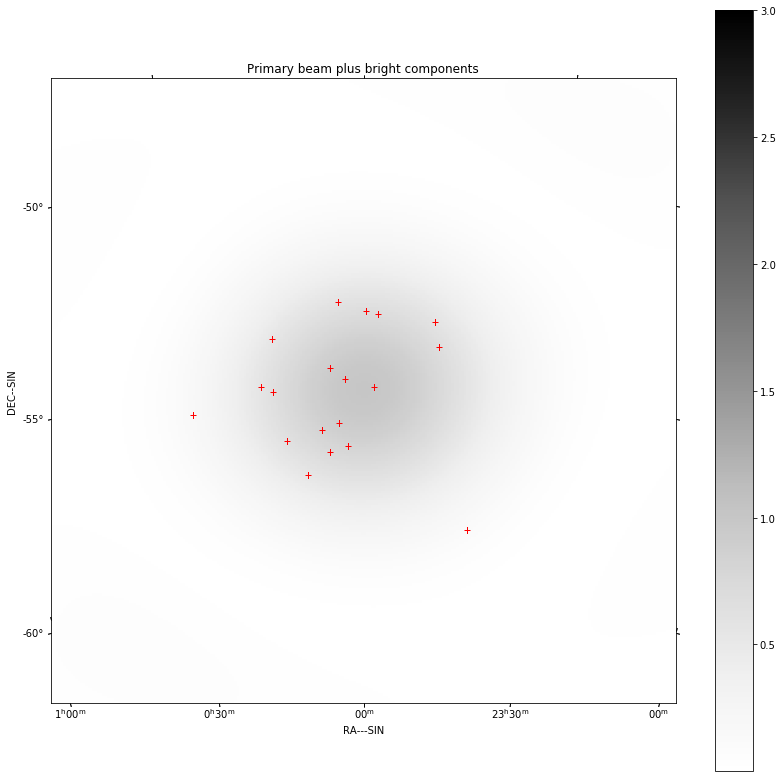

In [17]:
flux_limit=0.1
beam = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
beam = create_low_test_beam(beam)

original_gleam_components = create_low_test_skycomponents_from_gleam(
    flux_limit=flux_limit,
    phasecentre=phasecentre,
    frequency=frequency,
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=0.2)

pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components,
                                                 beam)
bright_components = filter_skycomponents_by_flux(
    pb_gleam_components, flux_min=1.0)
all_components = filter_skycomponents_by_flux(
    pb_gleam_components, flux_min=flux_limit)

show_image(
    beam,
    components=bright_components,
    cm='Greys',
    title='Primary beam plus bright components',
    vmax=3.0)

lprint("Number of bright components %d" % len(bright_components))

Number of components 269


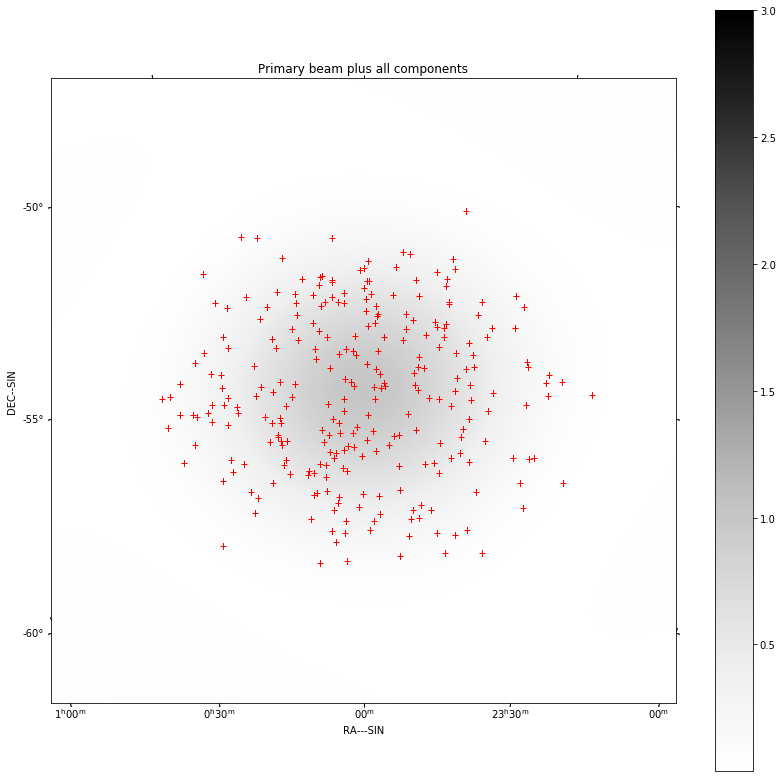

In [18]:
show_image(
    beam,
    components=all_components,
    cm='Greys',
    title='Primary beam plus all components',
vmax=3.0)

lprint("Number of components %d" % len(all_components))

In [19]:

component_h5 = export_skycomponent_to_hdf5(all_components, 'all_components.hdf5')

### We want to cluster the component by distance

In [20]:
idx, d2d = select_neighbouring_components(all_components, bright_components)

In [21]:
from itertools import compress

comps_lists = list()

for comp_id in numpy.unique(idx):
    comps = list(compress(all_components, idx==comp_id))
    comps_lists.append(comps)
    

Number of components 269


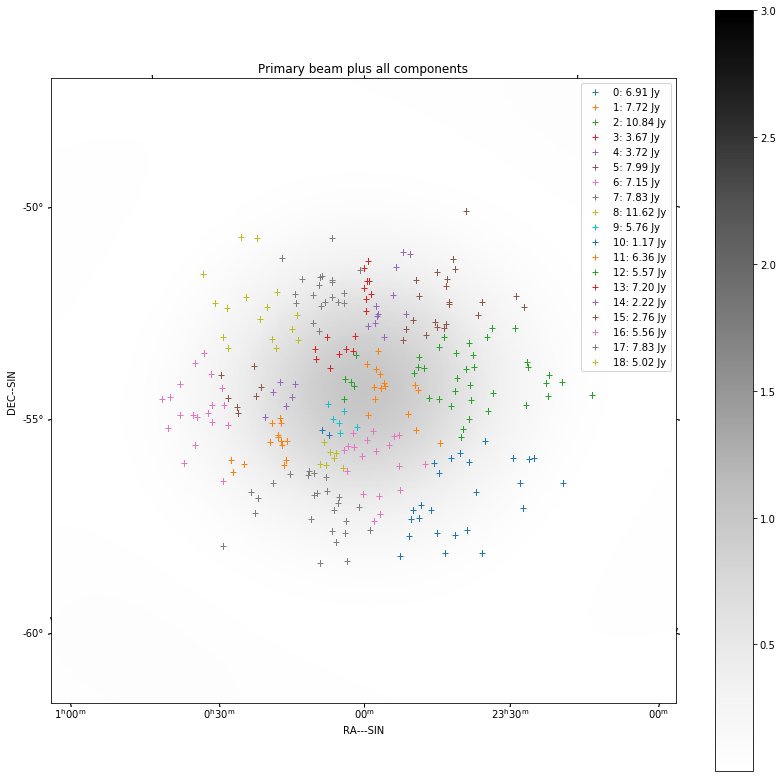

In [22]:
show_image(
    beam,
    cm='Greys',
    title='Primary beam plus all components',
vmax = 3.0)

from astropy.wcs.utils import skycoord_to_pixel
for comp_id, comps in enumerate(comps_lists):    
    flux = numpy.sum([c.flux[0,0] for c in comps])
    directions = SkyCoord([u.rad * c.direction.ra.rad for c in comps],
                          [u.rad * c.direction.dec.rad for c in comps])
    x, y = skycoord_to_pixel(directions, beam.wcs, 0, 'wcs')
    plt.plot(x, y, '+', label='%d: %.2f Jy' % (comp_id, flux))
    
plt.legend()

lprint("Number of components %d" % len(all_components))